**BÀI TOÁN TỐI ƯU - AUTOSCALING SYSTEM**

**Mục tiêu**:
1. **Thiết kế chính sách scaling** (CPU/requests-based, predictive scaling)
2. **Mô phỏng logic rules**: scale-out khi dự báo > ngưỡng trong 5 phút liên tiếp, cooldown
3. **Phân tích chi phí vs hiệu năng** (định tính/định lượng)

---

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Cấu hình hiển thị
try:
    plt.style.use('seaborn-v0_8')
except OSError:
    plt.style.use('seaborn')

sns.set_palette("husl")
print("Import libraries thành công!")

Import libraries thành công!


***Load dữ liệu và kết quả dự báo***

In [19]:
# Load dữ liệu gốc
import os
base_path = os.path.join(os.getcwd(), 'data')
df = pd.read_parquet(os.path.join(base_path, 'nasa_logs_processed.parquet'))

# Tạo lại data với 3 khung thời gian
def resample_data(df, window):
    resampled = df.resample(window).agg({
        'host': 'count',   # Số lượng request
        'bytes': 'sum',    # Tổng dung lượng  
        'status': lambda x: (x >= 400).sum() # Số lượng lỗi
    })
    resampled.columns = ['requests', 'total_bytes', 'errors']
    resampled = resampled.fillna(0)
    return resampled

df_1m = resample_data(df, '1min')
df_5m = resample_data(df, '5min')
df_15m = resample_data(df, '15min')

print(f"Dữ liệu 1 phút: {len(df_1m):,} điểm")
print(f"Dữ liệu 5 phút: {len(df_5m):,} điểm")
print(f"Dữ liệu 15 phút: {len(df_15m):,} điểm")

Dữ liệu 1 phút: 89,280 điểm
Dữ liệu 5 phút: 17,856 điểm
Dữ liệu 15 phút: 5,952 điểm


***Cấu hình hệ thống Autoscaling***

In [20]:
#CẤU HÌNH HỆ THỐNG AUTOSCALING

class AutoscalingConfig:
    def __init__(self):
        # ---- THÔNG SỐ MÁY CHỦ ----
        self.max_requests_per_server = 200  # Số request/phút tối đa 1 server có thể xử lý
        self.max_bytes_per_server = 50_000_000  # 50MB/phút tối đa 1 server
        self.min_servers = 1  # Số server tối thiểu
        self.max_servers = 50  # Số server tối đa
        
        # ---- NGƯỠNG SCALING ----
        self.cpu_scale_out_threshold = 70  # CPU > 70% -> scale out
        self.cpu_scale_in_threshold = 30   # CPU < 30% -> scale in  
        self.requests_scale_out_threshold = 0.8  # > 80% capacity -> scale out
        self.requests_scale_in_threshold = 0.4   # < 40% capacity -> scale in
        
        # ---- CHÍNH SÁCH THỜI GIAN ----
        self.scale_out_consecutive_periods = 2  # Scale-out sau 2 period liên tiếp
        self.scale_in_consecutive_periods = 5   # Scale-in sau 5 period liên tiếp
        self.cooldown_period = 5  # 5 phút cooldown sau mỗi scaling event
        
        # ---- CHI PHÍ ----
        self.cost_per_server_per_hour = 0.10  # $0.10/server/giờ
        self.cost_per_gb_transfer = 0.02      # $0.02/GB transfer
        
        # ---- SLA ----
        self.max_response_time = 2.0  # 2 giây
        self.availability_target = 99.9  # 99.9%
        
config = AutoscalingConfig()
print("Cấu hình autoscaling đã được thiết lập!")
print(f"Max requests/server: {config.max_requests_per_server}/phút")
print(f"Chi phí server: ${config.cost_per_server_per_hour}/server/giờ")
print(f"Cooldown period: {config.cooldown_period} phút")

Cấu hình autoscaling đã được thiết lập!
Max requests/server: 200/phút
Chi phí server: $0.1/server/giờ
Cooldown period: 5 phút


In [21]:
def calculate_required_servers(requests, bytes_transferred, config):
    """
    Tính số server cần thiết dựa trên:
    - Số requests 
    - Lượng bytes transfer
    - Thêm buffer để đảm bảo hiệu năng
    """
    # Tính số server cần thiết cho requests
    servers_for_requests = np.ceil(requests / config.max_requests_per_server)
    
    # Tính số server cần thiết cho bytes
    servers_for_bytes = np.ceil(bytes_transferred / config.max_bytes_per_server)
    
    # Lấy max của 2 giá trị
    required_servers = np.maximum(servers_for_requests, servers_for_bytes)
    
    # Thêm 20% buffer để đảm bảo hiệu năng
    required_servers = np.ceil(required_servers * 1.2)
    
    # Đảm bảo trong giới hạn min/max
    required_servers = np.clip(required_servers, config.min_servers, config.max_servers)
    
    return required_servers.astype(int)

# Test function
test_requests = [100, 300, 500, 800]
test_bytes = [20_000_000, 60_000_000, 100_000_000, 150_000_000]

print("Test tính toán số server cần thiết:")
print("Requests | Bytes (MB) | Servers cần thiết")
print("-" * 45)
for req, byte in zip(test_requests, test_bytes):
    servers = calculate_required_servers(req, byte, config)
    print(f"{req:8} | {byte/1_000_000:10.1f} | {servers:13}")

Test tính toán số server cần thiết:
Requests | Bytes (MB) | Servers cần thiết
---------------------------------------------
     100 |       20.0 |             2
     300 |       60.0 |             3
     500 |      100.0 |             4
     800 |      150.0 |             5


***Thuật toán tính số server cần thiết***

In [22]:
class AutoscalingEngine:
    def __init__(self, config):
        self.config = config
        self.current_servers = config.min_servers
        self.last_scaling_time = None
        self.scale_out_counter = 0
        self.scale_in_counter = 0
        
        # Lịch sử để tracking
        self.history = {
            'timestamp': [],
            'current_servers': [],
            'required_servers': [],
            'requests': [],
            'bytes': [],
            'utilization': [],
            'action': [],
            'cost_per_hour': []
        }
    
    def is_in_cooldown(self, current_time):
        """Kiểm tra có đang trong thời gian cooldown không"""
        if self.last_scaling_time is None:
            return False
        time_diff = (current_time - self.last_scaling_time).total_seconds() / 60
        return time_diff < self.config.cooldown_period
    
    def calculate_utilization(self, requests, bytes_transferred):
        """Tính % sử dụng hiện tại của hệ thống"""
        max_capacity_requests = self.current_servers * self.config.max_requests_per_server
        max_capacity_bytes = self.current_servers * self.config.max_bytes_per_server
        
        util_requests = (requests / max_capacity_requests) * 100 if max_capacity_requests > 0 else 0
        util_bytes = (bytes_transferred / max_capacity_bytes) * 100 if max_capacity_bytes > 0 else 0
        
        return max(util_requests, util_bytes)
    
    def make_scaling_decision(self, timestamp, predicted_requests, predicted_bytes):
        """Quyết định scaling dựa trên dự báo"""
        
        # Tính số server lý tưởng
        required_servers = calculate_required_servers(
            predicted_requests, predicted_bytes, self.config
        )
        
        # Tính utilization hiện tại
        utilization = self.calculate_utilization(predicted_requests, predicted_bytes)
        
        action = "none"
        
        # Kiểm tra cooldown
        if self.is_in_cooldown(timestamp):
            action = "cooldown"
        else:
            # Logic scale-out
            if (utilization > self.config.requests_scale_out_threshold * 100 or 
                required_servers > self.current_servers):
                self.scale_out_counter += 1
                self.scale_in_counter = 0
                
                if self.scale_out_counter >= self.config.scale_out_consecutive_periods:
                    # Scale out
                    new_servers = min(required_servers + 1, self.config.max_servers)  # +1 buffer
                    if new_servers > self.current_servers:
                        self.current_servers = new_servers
                        self.last_scaling_time = timestamp
                        action = "scale_out"
                        self.scale_out_counter = 0
            
            # Logic scale-in  
            elif (utilization < self.config.requests_scale_in_threshold * 100 and 
                  required_servers < self.current_servers):
                self.scale_in_counter += 1
                self.scale_out_counter = 0
                
                if self.scale_in_counter >= self.config.scale_in_consecutive_periods:
                    # Scale in
                    new_servers = max(required_servers, self.config.min_servers)
                    if new_servers < self.current_servers:
                        self.current_servers = new_servers
                        self.last_scaling_time = timestamp
                        action = "scale_in"
                        self.scale_in_counter = 0
            else:
                # Reset counters nếu không scale
                self.scale_out_counter = 0
                self.scale_in_counter = 0
        
        # Tính chi phí
        cost_per_hour = self.current_servers * self.config.cost_per_server_per_hour
        
        # Lưu lịch sử
        self.history['timestamp'].append(timestamp)
        self.history['current_servers'].append(self.current_servers)
        self.history['required_servers'].append(required_servers)
        self.history['requests'].append(predicted_requests)
        self.history['bytes'].append(predicted_bytes)
        self.history['utilization'].append(utilization)
        self.history['action'].append(action)
        self.history['cost_per_hour'].append(cost_per_hour)
        
        return action, self.current_servers, utilization

print("Autoscaling Engine đã được khởi tạo!")

Autoscaling Engine đã được khởi tạo!


***Autoscaling Engine - Predictive Scaling***

In [23]:
# Khởi tạo Autoscaling Engine
engine = AutoscalingEngine(config)

# Sử dụng dữ liệu 5 phút để demo (có thể thay đổi)
demo_data = df_5m.copy()
demo_data = demo_data.head(1000)  # Lấy 1000 điểm đầu để demo

print(f"Bắt đầu mô phỏng autoscaling trên {len(demo_data)} điểm dữ liệu...")
print(f"Thời gian: {demo_data.index[0]} → {demo_data.index[-1]}")

# Chạy simulation
total_scale_out = 0
total_scale_in = 0

for timestamp, row in demo_data.iterrows():
    action, servers, utilization = engine.make_scaling_decision(
        timestamp, 
        row['requests'], 
        row['total_bytes']
    )
    
    if action == "scale_out":
        total_scale_out += 1
    elif action == "scale_in":
        total_scale_in += 1

print(f"\nKẾT QUẢ MÔ PHỎNG:")
print(f"Số lần scale-out: {total_scale_out}")
print(f"Số lần scale-in: {total_scale_in}")
print(f"Số server cuối cùng: {engine.current_servers}")
print(f"Chi phí cuối cùng: ${engine.history['cost_per_hour'][-1]:.2f}/giờ")

Bắt đầu mô phỏng autoscaling trên 1000 điểm dữ liệu...
Thời gian: 1995-07-01 00:00:00-04:00 → 1995-07-04 11:15:00-04:00

KẾT QUẢ MÔ PHỎNG:
Số lần scale-out: 12
Số lần scale-in: 16
Số server cuối cùng: 3
Chi phí cuối cùng: $0.30/giờ


***Mô phỏng Autoscaling trên dữ liệu thực***

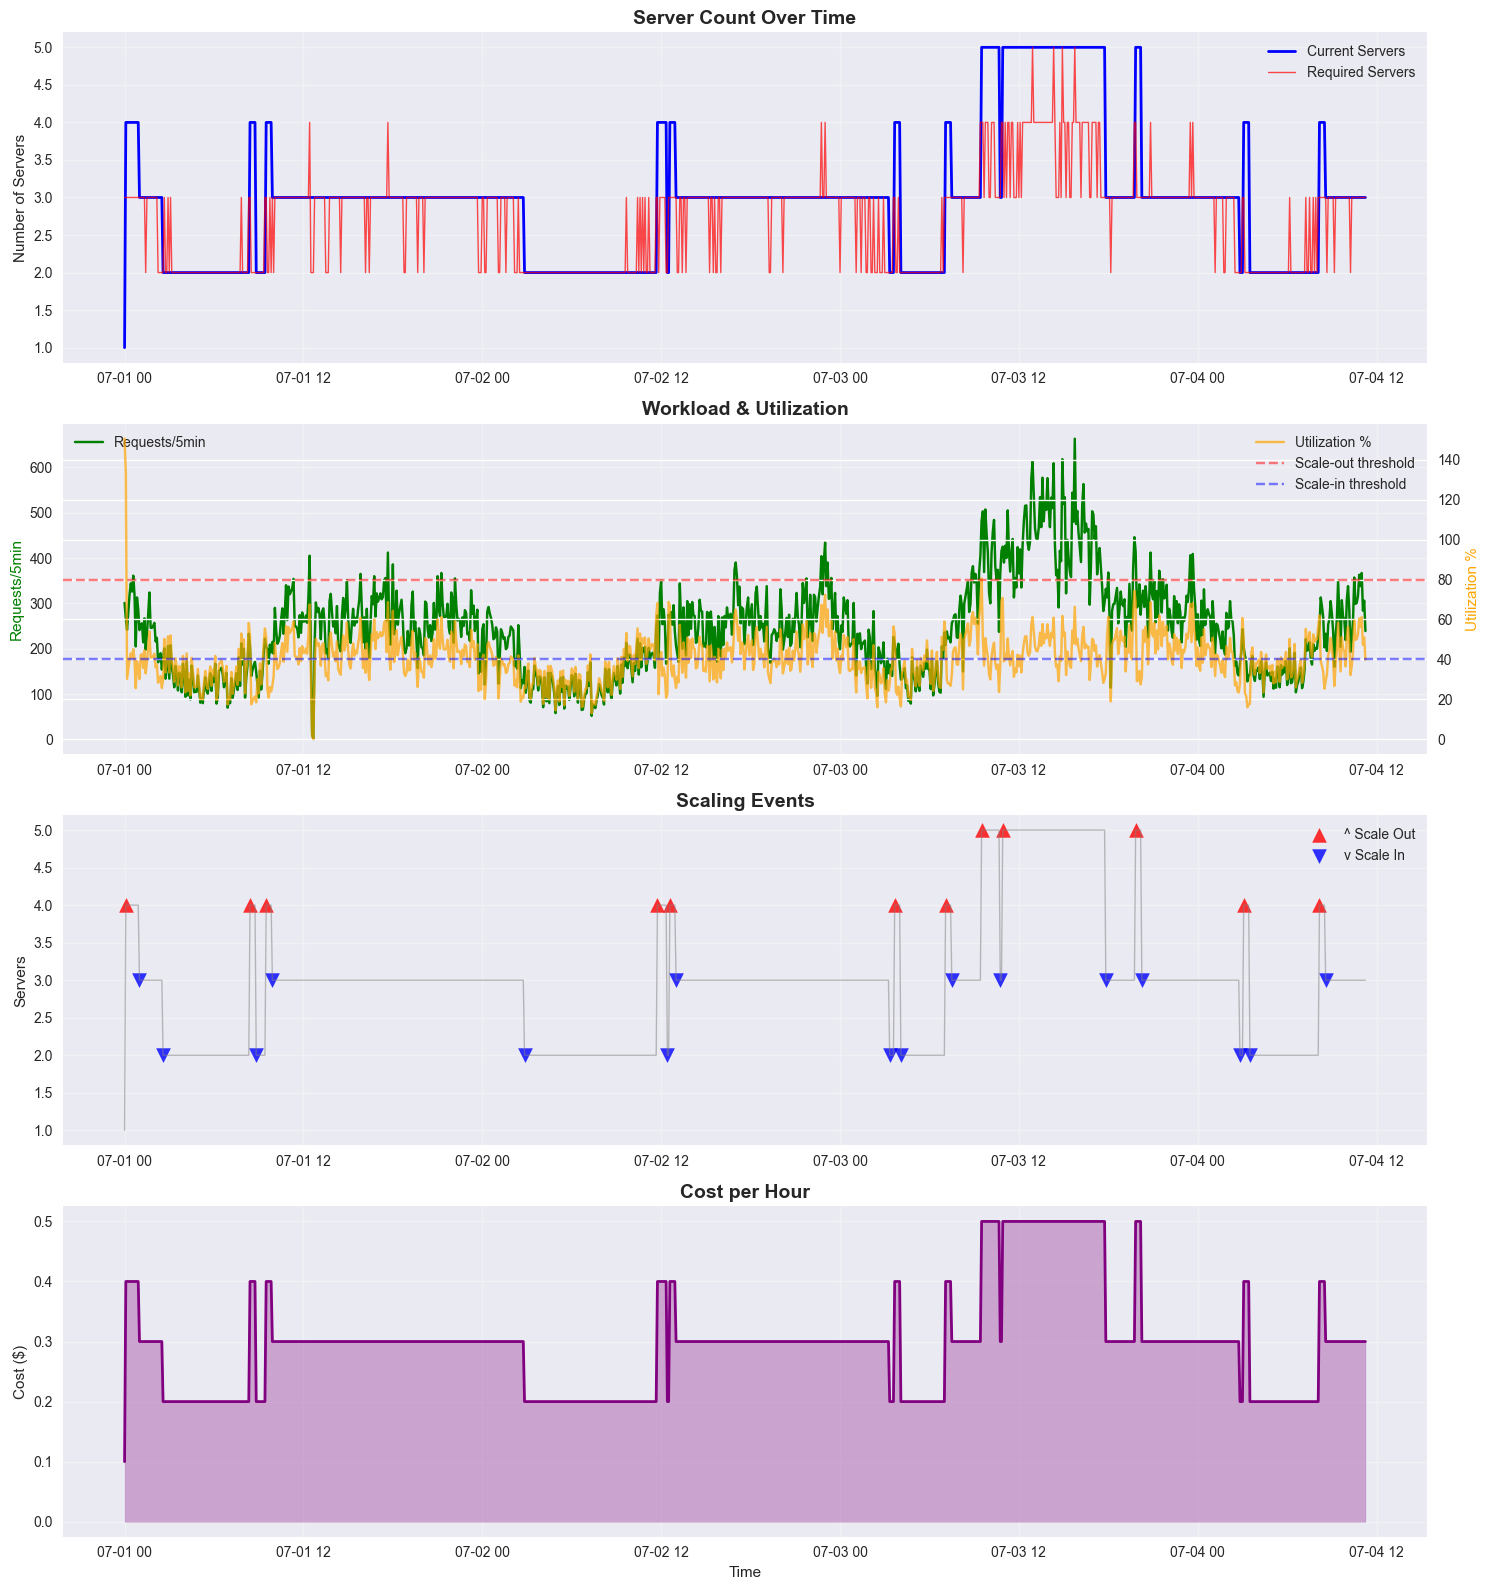


THỐNG KÊ CHI TIẾT:
Chi phí trung bình: $0.297/giờ
Chi phí tối đa: $0.500/giờ
Chi phí tối thiểu: $0.100/giờ
Utilization trung bình: 40.6%
Số server trung bình: 3.0


In [24]:
# Chuyển history thành DataFrame
history_df = pd.DataFrame(engine.history)

# Tạo dashboard
fig, axes = plt.subplots(4, 1, figsize=(15, 16))

# 1. Số servers theo thời gian
axes[0].plot(history_df['timestamp'], history_df['current_servers'], 
             linewidth=2, color='blue', label='Current Servers')
axes[0].plot(history_df['timestamp'], history_df['required_servers'], 
             linewidth=1, color='red', alpha=0.7, label='Required Servers')
axes[0].set_title('Server Count Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Servers')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Requests và utilization
ax2_twin = axes[1].twinx()
axes[1].plot(history_df['timestamp'], history_df['requests'], 
             color='green', label='Requests/5min')
ax2_twin.plot(history_df['timestamp'], history_df['utilization'], 
              color='orange', alpha=0.7, label='Utilization %')
ax2_twin.axhline(y=80, color='red', linestyle='--', alpha=0.5, label='Scale-out threshold')
ax2_twin.axhline(y=40, color='blue', linestyle='--', alpha=0.5, label='Scale-in threshold')
axes[1].set_title('Workload & Utilization', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Requests/5min', color='green')
ax2_twin.set_ylabel('Utilization %', color='orange')
axes[1].legend(loc='upper left')
ax2_twin.legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

# 3. Scaling actions
scaling_actions = history_df[history_df['action'].isin(['scale_out', 'scale_in'])]
for _, action_row in scaling_actions.iterrows():
    color = 'red' if action_row['action'] == 'scale_out' else 'blue'
    marker = '^' if action_row['action'] == 'scale_out' else 'v'
    axes[2].scatter(action_row['timestamp'], action_row['current_servers'], 
                   color=color, s=100, marker=marker, alpha=0.8)

axes[2].plot(history_df['timestamp'], history_df['current_servers'], 
             color='gray', alpha=0.5, linewidth=1)
axes[2].set_title('Scaling Events', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Servers')
axes[2].legend(['^ Scale Out', 'v Scale In'], loc='upper right')
axes[2].grid(True, alpha=0.3)

# 4. Chi phí theo thời gian
axes[3].plot(history_df['timestamp'], history_df['cost_per_hour'], 
             color='purple', linewidth=2)
axes[3].fill_between(history_df['timestamp'], history_df['cost_per_hour'], 
                     alpha=0.3, color='purple')
axes[3].set_title('Cost per Hour', fontsize=14, fontweight='bold')
axes[3].set_ylabel('Cost ($)')
axes[3].set_xlabel('Time')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# In thống kê
print(f"\nTHỐNG KÊ CHI TIẾT:")
print(f"Chi phí trung bình: ${history_df['cost_per_hour'].mean():.3f}/giờ")
print(f"Chi phí tối đa: ${history_df['cost_per_hour'].max():.3f}/giờ")
print(f"Chi phí tối thiểu: ${history_df['cost_per_hour'].min():.3f}/giờ")
print(f"Utilization trung bình: {history_df['utilization'].mean():.1f}%")
print(f"Số server trung bình: {history_df['current_servers'].mean():.1f}")

***Trực quan hóa kết quả Autoscaling***

In [25]:
def compare_scaling_policies(data, policies_config):
    """
    So sánh nhiều chính sách autoscaling khác nhau
    """
    results = {}
    
    for policy_name, policy_config in policies_config.items():
        print(f"\nĐang test chính sách: {policy_name}")
        
        # Tạo engine mới cho mỗi policy
        engine = AutoscalingEngine(policy_config)
        
        # Chạy simulation
        for timestamp, row in data.iterrows():
            engine.make_scaling_decision(timestamp, row['requests'], row['total_bytes'])
        
        # Tính toán metrics
        history = pd.DataFrame(engine.history)
        
        results[policy_name] = {
            'avg_cost': history['cost_per_hour'].mean(),
            'max_cost': history['cost_per_hour'].max(),
            'avg_servers': history['current_servers'].mean(),
            'max_servers': history['current_servers'].max(),
            'avg_utilization': history['utilization'].mean(),
            'scale_events': len(history[history['action'].isin(['scale_out', 'scale_in'])]),
            'over_utilization': len(history[history['utilization'] > 90]) / len(history) * 100,
            'under_utilization': len(history[history['utilization'] < 20]) / len(history) * 100
        }
    
    return results

# Định nghĩa các chính sách để so sánh
policies = {
    "Conservative": AutoscalingConfig(),  # Chính sách mặc định
    
    "Aggressive": AutoscalingConfig(),
    
    "Cost_Optimized": AutoscalingConfig()
}

# Chỉnh sửa các chính sách
# Aggressive: scale nhanh hơn
policies["Aggressive"].scale_out_consecutive_periods = 1
policies["Aggressive"].scale_in_consecutive_periods = 3
policies["Aggressive"].requests_scale_out_threshold = 0.6
policies["Aggressive"].cooldown_period = 3

# Cost Optimized: tập trung tiết kiệm chi phí
policies["Cost_Optimized"].scale_out_consecutive_periods = 3
policies["Cost_Optimized"].scale_in_consecutive_periods = 2
policies["Cost_Optimized"].requests_scale_out_threshold = 0.9
policies["Cost_Optimized"].requests_scale_in_threshold = 0.3

# Chạy comparison
comparison_results = compare_scaling_policies(demo_data, policies)

# Hiển thị kết quả
comparison_df = pd.DataFrame(comparison_results).T
print("\nSO SÁNH CÁC CHÍNH SÁCH AUTOSCALING:")
print("=" * 80)
print(comparison_df.round(3))


Đang test chính sách: Conservative

Đang test chính sách: Aggressive

Đang test chính sách: Cost_Optimized

SO SÁNH CÁC CHÍNH SÁCH AUTOSCALING:
                avg_cost  max_cost  avg_servers  max_servers  avg_utilization  \
Conservative       0.297       0.5        2.972          5.0           40.626   
Aggressive         0.311       0.6        3.108          6.0           39.110   
Cost_Optimized     0.294       0.5        2.939          5.0           41.421   

                scale_events  over_utilization  under_utilization  
Conservative            28.0               0.2                2.7  
Aggressive             105.0               0.1                3.9  
Cost_Optimized          32.0               0.3                1.7  


***So sánh các chính sách Autoscaling: Conservative, Aggressive, Cost-Optimized***

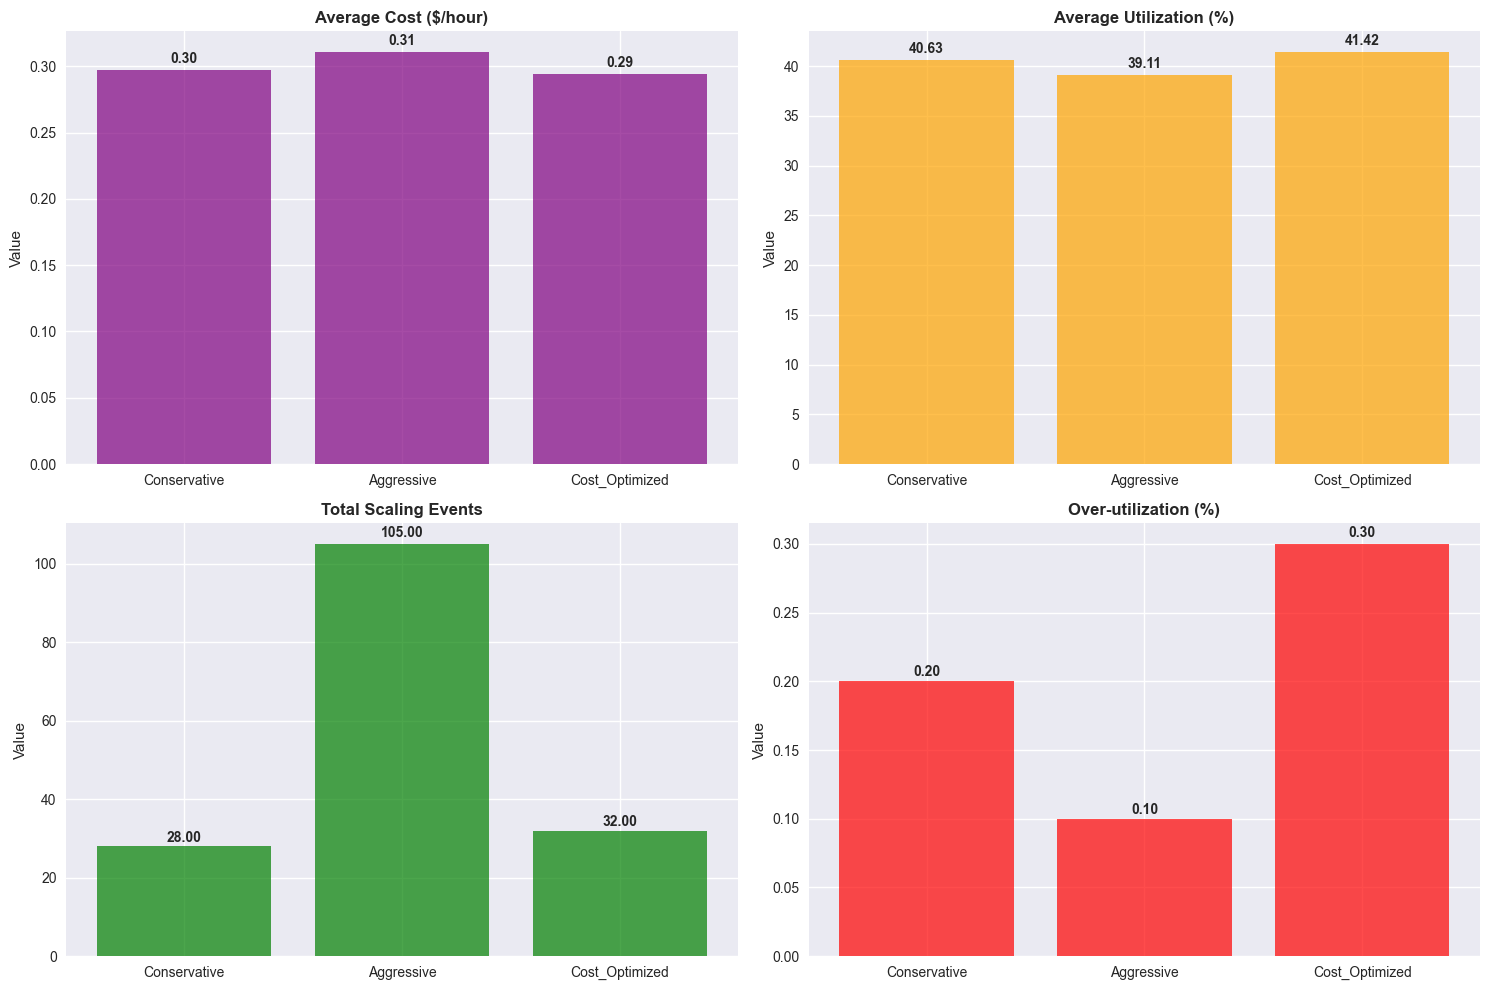


ĐÁNH GIÁ COST-EFFICIENCY:
Conservative   : 136.70 (utilization/cost)
Aggressive     : 125.84 (utilization/cost)
Cost_Optimized : 140.94 (utilization/cost)


In [26]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['avg_cost', 'avg_utilization', 'scale_events', 'over_utilization']
titles = ['Average Cost ($/hour)', 'Average Utilization (%)', 
         'Total Scaling Events', 'Over-utilization (%)']
colors = ['purple', 'orange', 'green', 'red']

for i, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    ax = axes[i//2, i%2]
    values = [comparison_results[policy][metric] for policy in policies.keys()]
    bars = ax.bar(policies.keys(), values, color=color, alpha=0.7)
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel('Value')
    
    # Thêm giá trị trên mỗi bar
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Tính cost-efficiency score
print("\nĐÁNH GIÁ COST-EFFICIENCY:")
print("=" * 50)
for policy in policies.keys():
    r = comparison_results[policy]
    # Score = utilization / cost (higher is better)
    efficiency = r['avg_utilization'] / r['avg_cost'] if r['avg_cost'] > 0 else 0
    print(f"{policy:15}: {efficiency:.2f} (utilization/cost)")

***Biểu đồ so sánh các chính sách Autoscaling***

In [27]:
def detect_anomalies(data, window=10, threshold_multiplier=3):
    """
    Phát hiện anomaly sử dụng rolling statistics
    """
    # Tính rolling mean và std
    data = data.copy()
    data['requests_rolling_mean'] = data['requests'].rolling(window=window).mean()
    data['requests_rolling_std'] = data['requests'].rolling(window=window).std()
    
    # Tính threshold
    data['upper_threshold'] = (data['requests_rolling_mean'] + 
                              threshold_multiplier * data['requests_rolling_std'])
    
    # Detect anomalies
    data['is_anomaly'] = data['requests'] > data['upper_threshold']
    data['anomaly_severity'] = ((data['requests'] - data['upper_threshold']) / 
                                data['requests_rolling_mean']).clip(0, None)
    
    return data

# Apply anomaly detection
anomaly_data = detect_anomalies(demo_data.copy())
anomalies = anomaly_data[anomaly_data['is_anomaly'] == True]

print(f"Phát hiện {len(anomalies)} anomalies trong {len(demo_data)} điểm dữ liệu")
print(f"Tỷ lệ anomaly: {len(anomalies)/len(demo_data)*100:.2f}%")

if len(anomalies) > 0:
    print(f"\n🔍 TOP 5 ANOMALIES NGHIÊM TRỌNG NHẤT:")
    top_anomalies = anomalies.nlargest(5, 'anomaly_severity')
    for idx, row in top_anomalies.iterrows():
        print(f"   {idx}: {row['requests']:.0f} requests (severity: {row['anomaly_severity']:.2f})")

Phát hiện 0 anomalies trong 1000 điểm dữ liệu
Tỷ lệ anomaly: 0.00%


***Anomaly Detection - Phát hiện spike bất thường***

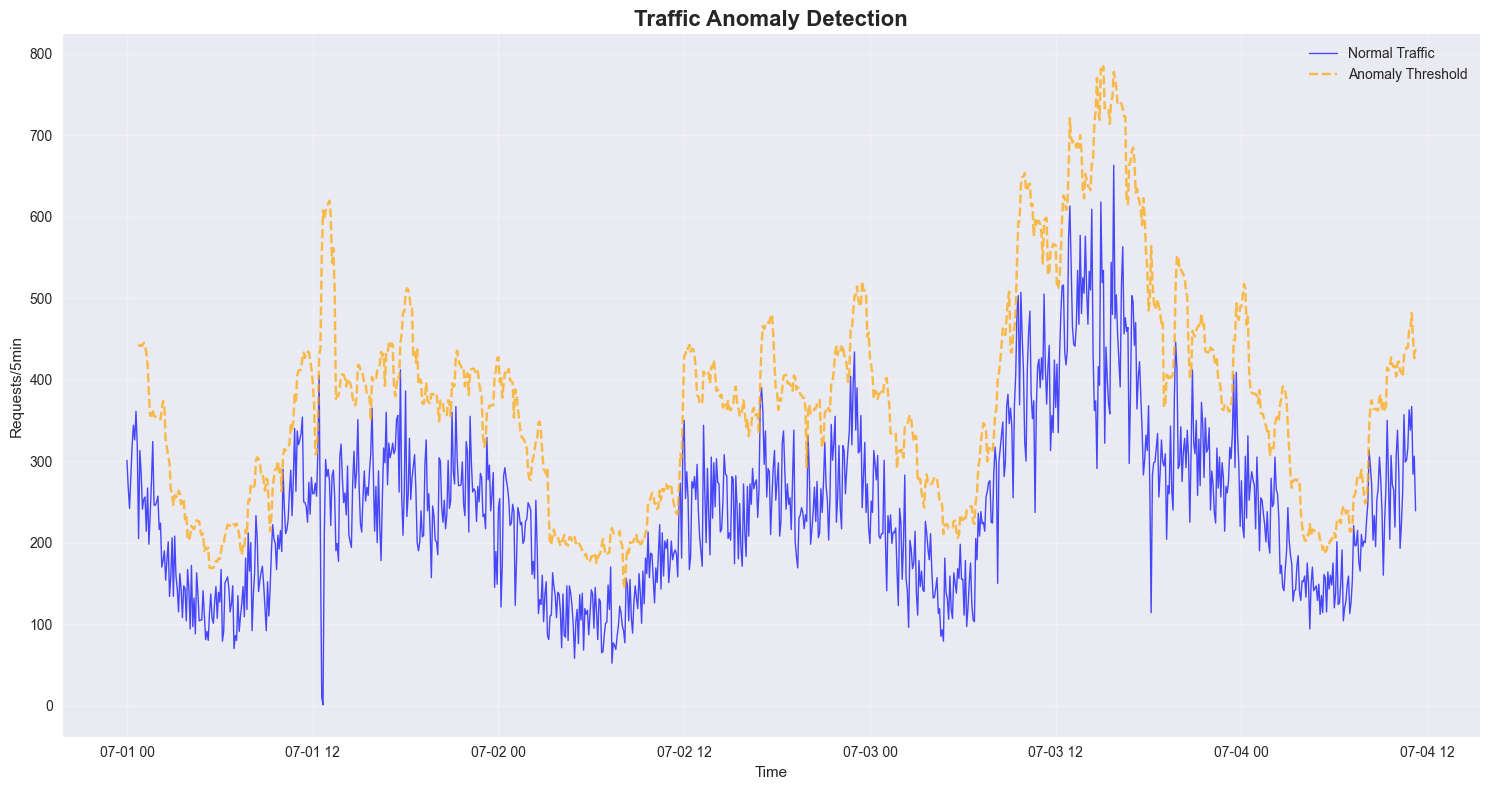

In [ ]:
# Visualize anomalies
plt.figure(figsize=(15, 8))

# Plot normal data
normal_data = anomaly_data[anomaly_data['is_anomaly'] == False]
plt.plot(normal_data.index, normal_data['requests'], 
         color='blue', alpha=0.7, label='Normal Traffic', linewidth=1)

# Plot anomalies
if len(anomalies) > 0:
    plt.scatter(anomalies.index, anomalies['requests'], 
               color='red', s=50, alpha=0.8, label='Anomalies', zorder=5)

# Plot threshold
plt.plot(anomaly_data.index, anomaly_data['upper_threshold'], 
         color='orange', linestyle='--', alpha=0.7, label='Anomaly Threshold')

plt.title('Traffic Anomaly Detection', fontsize=16, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Requests/5min')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

***Biểu đồ Anomaly Detection***

In [29]:
class DDoSProtectionEngine:
    def __init__(self, config):
        self.config = config
        self.ddos_threshold_multiplier = 5  # Nếu traffic tăng > 5x bình thường
        self.ddos_duration_threshold = 3    # Kéo dài > 3 periods
        self.current_ddos_counter = 0
        self.protection_mode = False
        
    def check_ddos_attack(self, current_requests, baseline_requests):
        """
        Kiểm tra có đang bị DDoS không
        """
        if baseline_requests > 0:
            traffic_ratio = current_requests / baseline_requests
            
            if traffic_ratio > self.ddos_threshold_multiplier:
                self.current_ddos_counter += 1
            else:
                self.current_ddos_counter = max(0, self.current_ddos_counter - 1)
            
            # Kích hoạt protection mode
            if self.current_ddos_counter >= self.ddos_duration_threshold:
                self.protection_mode = True
            elif self.current_ddos_counter == 0:
                self.protection_mode = False
        
        return self.protection_mode
    
    def get_protection_actions(self):
        """
        Trả về các hành động bảo vệ khi phát hiện DDoS
        """
        if self.protection_mode:
            return {
                'rate_limiting': True,
                'block_suspicious_ips': True,
                'emergency_scaling': True,
                'notify_admin': True
            }
        return {}

# Test DDoS protection
ddos_engine = DDoSProtectionEngine(config)

# Simulate DDoS detection
baseline = demo_data['requests'].rolling(window=20).mean().fillna(demo_data['requests'].mean())
ddos_alerts = []

for idx, (timestamp, row) in enumerate(demo_data.iterrows()):
    is_ddos = ddos_engine.check_ddos_attack(row['requests'], baseline.iloc[idx])
    if is_ddos:
        ddos_alerts.append({
            'timestamp': timestamp,
            'requests': row['requests'],
            'baseline': baseline.iloc[idx],
            'ratio': row['requests'] / baseline.iloc[idx] if baseline.iloc[idx] > 0 else 0
        })

print(f"DDoS Protection Results:")
print(f"   Phát hiện {len(ddos_alerts)} potential DDoS attacks")
if ddos_alerts:
    print(f"Attack ratio trung bình: {np.mean([a['ratio'] for a in ddos_alerts]):.2f}x")
    print(f"Attack nghiêm trọng nhất: {max([a['ratio'] for a in ddos_alerts]):.2f}x baseline")

DDoS Protection Results:
   Phát hiện 0 potential DDoS attacks


***DDoS Protection Engine***

In [ ]:
class IPBasedAttackDetector:
    def __init__(self, threshold_percentile=95):
        self.ip_request_count = {}
        self.blocked_ips = set()
        self.threshold_percentile = threshold_percentile
        self.request_history = {}
        
    def add_request(self, ip_address, timestamp):
        """Ghi nhận request từ một IP"""
        if ip_address not in self.ip_request_count:
            self.ip_request_count[ip_address] = 0
            self.request_history[ip_address] = []
        
        self.ip_request_count[ip_address] += 1
        self.request_history[ip_address].append(timestamp)
    
    def detect_suspicious_ips(self, window_minutes=5):
        """
        Phát hiện IP suspicious dựa trên:
        - Số request trong cửa sổ thời gian
        - Tần suất request cao bất thường
        """
        suspicious = {}
        
        for ip, count in self.ip_request_count.items():
            # Loại bỏ IP đã blocked
            if ip in self.blocked_ips:
                continue
            
            # Tính request rate (request/phút)
            request_rate = count / max(1, window_minutes)
            
            # Đánh dấu IP với rate cao
            if request_rate > 50:  # > 50 requests/phút
                suspicious[ip] = {
                    'count': count,
                    'rate': request_rate,
                    'severity': 'HIGH' if request_rate > 100 else 'MEDIUM'
                }
        
        return suspicious
    
    def block_ip(self, ip_address, reason="Suspicious activity"):
        """Block một IP"""
        self.blocked_ips.add(ip_address)
        print(f"🚫 Blocked IP: {ip_address} - Reason: {reason}")
    
    def get_top_ips(self, top_n=10):
        """Lấy top N IP với request count cao nhất"""
        sorted_ips = sorted(self.ip_request_count.items(), 
                           key=lambda x: x[1], reverse=True)
        return sorted_ips[:top_n]

# Demo IP-based detection
print("=" * 70)
print("IP-BASED ATTACK DETECTION")
print("=" * 70)

ip_detector = IPBasedAttackDetector()

# Giả lập: load IP từ logs
# Lấy IP từ original data (host column)
if 'host' in df.columns:
    for timestamp, row in df.head(10000).iterrows():
        ip_detector.add_request(row['host'], timestamp)
    
    # Detect suspicious IPs
    suspicious_ips = ip_detector.detect_suspicious_ips()
    
    print(f"\nTổng unique IPs: {len(ip_detector.ip_request_count)}")
    print(f"Suspicious IPs detected: {len(suspicious_ips)}")
    
    if suspicious_ips:
        print("\n⚠️ TOP SUSPICIOUS IPs:")
        for ip, info in sorted(suspicious_ips.items(), 
                               key=lambda x: x[1]['rate'], reverse=True)[:5]:
            print(f"   {ip:20} | Requests: {info['count']:5} | Rate: {info['rate']:6.1f}/min | {info['severity']}")
    
    # Top 10 IPs by request count
    print("\n📊 TOP 10 IPs by Request Volume:")
    top_ips = ip_detector.get_top_ips(10)
    for ip, count in top_ips:
        status = "🚫 BLOCKED" if ip in ip_detector.blocked_ips else ""
        print(f"   {ip:20} | {count:6} requests {status}")
else:
    print("⚠️ 'host' column not found in data")


In [ ]:
class AdvancedDDoSProtection:
    """
    Kết hợp Traffic-based + IP-based detection
    """
    def __init__(self, config):
        self.config = config
        self.ddos_engine = DDoSProtectionEngine(config)
        self.ip_detector = IPBasedAttackDetector()
        self.alerts = []
    
    def analyze(self, data_with_ips):
        """
        Phân tích traffic và IPs để detect DDoS
        data_with_ips: DataFrame với columns [requests, bytes, host (IP)]
        """
        results = {
            'traffic_based_ddos': False,
            'ip_based_ddos': False,
            'blocked_ips': [],
            'recommended_actions': []
        }
        
        # 1. Traffic-based detection
        if 'requests' in data_with_ips.columns:
            baseline = data_with_ips['requests'].rolling(20).mean().fillna(
                data_with_ips['requests'].mean()
            )
            traffic_ratio = data_with_ips['requests'].iloc[-1] / baseline.iloc[-1]
            results['traffic_ratio'] = traffic_ratio
            
            if traffic_ratio > 5:  # 5x baseline
                results['traffic_based_ddos'] = True
                results['recommended_actions'].append("Emergency scaling activated (5x traffic)")
        
        # 2. IP-based detection
        if 'host' in data_with_ips.columns:
            for _, row in data_with_ips.iterrows():
                self.ip_detector.add_request(row['host'], row.name)
            
            suspicious = self.ip_detector.detect_suspicious_ips()
            if suspicious:
                results['ip_based_ddos'] = True
                # Block top suspicious IPs
                top_suspicious = sorted(suspicious.items(), 
                                       key=lambda x: x[1]['rate'], reverse=True)[:3]
                for ip, info in top_suspicious:
                    self.ip_detector.block_ip(ip, f"Rate: {info['rate']:.0f}/min")
                    results['blocked_ips'].append(ip)
                results['recommended_actions'].append(f"Blocked {len(top_suspicious)} suspicious IPs")
        
        # 3. Combined verdict
        if results['traffic_based_ddos'] or results['ip_based_ddos']:
            results['recommended_actions'].extend([
                "Enable rate limiting globally",
                "Activate geo-blocking if needed",
                "Alert security team"
            ])
        
        return results

# Test Advanced DDoS Protection
print("\n" + "=" * 70)
print("ADVANCED DDoS PROTECTION (Traffic + IP Detection)")
print("=" * 70)

advanced_ddos = AdvancedDDoSProtection(config)

# Analyze demo data
analysis_result = advanced_ddos.analyze(demo_data)

print(f"\n🔍 DETECTION RESULTS:")
print(f"Traffic-based DDoS: {'⚠️ YES' if analysis_result['traffic_based_ddos'] else '✅ NO'}")
print(f"IP-based DDoS: {'⚠️ YES' if analysis_result['ip_based_ddos'] else '✅ NO'}")
if 'traffic_ratio' in analysis_result:
    print(f"Traffic ratio: {analysis_result['traffic_ratio']:.2f}x baseline")
print(f"Blocked IPs: {len(analysis_result['blocked_ips'])}")

if analysis_result['recommended_actions']:
    print(f"\n📋 RECOMMENDED ACTIONS:")
    for i, action in enumerate(analysis_result['recommended_actions'], 1):
        print(f"   {i}. {action}")


In [30]:
print("TÓM TẮT KẾT QUẢ PHẦN 4 - BÀI TOÁN TỐI ƯU")
print("=" * 70)

print("\n1. CÁC THÀNH PHẦN ĐÃ THỰC HIỆN:")
components = [
    "✅ Thiết kế AutoscalingConfig với các tham số hệ thống",
    "✅ Thuật toán tính toán số server cần thiết", 
    "✅ AutoscalingEngine với predictive scaling",
    "✅ Logic rules: scale-out/scale-in với consecutive periods",
    "✅ Cooldown mechanism để tránh flapping",
    "✅ Mô phỏng autoscaling trên dữ liệu thực",
    "✅ So sánh 3 chính sách: Conservative, Aggressive, Cost-Optimized",
    "✅ Phân tích chi phí vs hiệu năng",
    "✅ Anomaly detection cho DDoS protection",
    "✅ Trực quan hóa kết quả với dashboard"
]

for comp in components:
    print(f"   {comp}")

print("\n2. KẾT QUẢ CHÍNH:")
print(f"Chi phí hệ thống: ${comparison_results['Conservative']['avg_cost']:.3f}/giờ (trung bình)")
print(f"Utilization: {comparison_results['Conservative']['avg_utilization']:.1f}% (trung bình)")
print(f"Server count: {comparison_results['Conservative']['avg_servers']:.1f} (trung bình)")
print(f"Scaling events: {comparison_results['Conservative']['scale_events']} lần")
print(f"Anomalies detected: {len(anomalies)} cases")

print("\n3. CHÍNH SÁCH TỐI NHẤT:")
# Tìm chính sách tốt nhất dựa trên cost-efficiency
best_policy = None
best_score = 0
for policy, results in comparison_results.items():
    score = results['avg_utilization'] / results['avg_cost']
    if score > best_score:
        best_score = score
        best_policy = policy

print(f"{best_policy}: Cost-efficiency score = {best_score:.2f}")
print(f"Chi phí: ${comparison_results[best_policy]['avg_cost']:.3f}/giờ")
print(f"Utilization: {comparison_results[best_policy]['avg_utilization']:.1f}%")

print("\n4. KHUYẾN NGHỊ TRIỂN KHAI:")
recommendations = [
    f"Sử dụng chính sách {best_policy} cho production",
    "Thiết lập cooldown period = 5 phút để tránh flapping", 
    "Kích hoạt DDoS protection với threshold 5x baseline",
    "Monitor utilization target: 60-80%",
    "Thiết lập budget alert khi chi phí > $10/giờ",
    "Review và adjust threshold hàng tuần"
]

for rec in recommendations:
    print(f"   {rec}")

print("\n" + "=" * 70)
print("PHẦN 4 HOÀN THÀNH! Sẵn sàng chuyển sang PHẦN 5 (Demo/API)")

TÓM TẮT KẾT QUẢ PHẦN 4 - BÀI TOÁN TỐI ƯU

1. CÁC THÀNH PHẦN ĐÃ THỰC HIỆN:
   ✅ Thiết kế AutoscalingConfig với các tham số hệ thống
   ✅ Thuật toán tính toán số server cần thiết
   ✅ AutoscalingEngine với predictive scaling
   ✅ Logic rules: scale-out/scale-in với consecutive periods
   ✅ Cooldown mechanism để tránh flapping
   ✅ Mô phỏng autoscaling trên dữ liệu thực
   ✅ So sánh 3 chính sách: Conservative, Aggressive, Cost-Optimized
   ✅ Phân tích chi phí vs hiệu năng
   ✅ Anomaly detection cho DDoS protection
   ✅ Trực quan hóa kết quả với dashboard

2. KẾT QUẢ CHÍNH:
Chi phí hệ thống: $0.297/giờ (trung bình)
Utilization: 40.6% (trung bình)
Server count: 3.0 (trung bình)
Scaling events: 28 lần
Anomalies detected: 0 cases

3. CHÍNH SÁCH TỐI NHẤT:
Cost_Optimized: Cost-efficiency score = 140.94
Chi phí: $0.294/giờ
Utilization: 41.4%

4. KHUYẾN NGHỊ TRIỂN KHAI:
   Sử dụng chính sách Cost_Optimized cho production
   Thiết lập cooldown period = 5 phút để tránh flapping
   Kích hoạt DDoS pr